## Data Preprocessing

In [277]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.express as px
from meteostat import Point, Daily, Hourly
import seaborn as sns
import numpy as np
import statsmodels.api as sm

from src.data import extract, load, transform
from zipfile import ZipFile
import kaggle
import os
import shutil
import requests
import urllib
from urllib.request import urlopen, urlretrieve
from io import BytesIO


# For models
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax
import time

1. The number cancelled or delayed fligts for the entire us. 
2. Trying to predict accumulated delay times for each time stamp.

In [2]:
DATA_DIR = "data/"

# # Download Fligt Delay Dataset form Kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files(
#     "robikscube/flight-delay-dataset-20182022",
#     path=DATA_DIR,
#     unzip=True,
# )

# for filename in os.listdir(DATA_DIR):
#     f = os.path.join(DATA_DIR, filename)
#     if f.endswith(".parquet") or filename == "Airlines.csv":
#         pass
#     else:
#         if os.path.isfile(f):
#             os.remove(f)
#         else:
#             shutil.rmtree(f)

## Download Location of airports
# urlretrieve(
#     "https://raw.githubusercontent.com/lxndrblz/Airports/main/airports.csv", 
#     DATA_DIR + "airports.csv"
#     )

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  

In [34]:
# main_df = extract.combine_parquet(data_path = "data/")
# main_df['count'] = 1

n = 50000
airport_df = pd.read_csv('data/airports.csv')
airline_df = pd.read_csv('data/Airlines.csv')

#delete this
# main_df = pd.read_parquet('data/Combined_flights_2021.parquet')

from pyarrow.parquet import ParquetFile
import pyarrow as pa 

pf = ParquetFile('data/Combined_flights_2021.parquet') 
first_ten_rows = next(pf.iter_batches(batch_size = n)) 
main_df = pa.Table.from_batches([first_ten_rows]).to_pandas() 

In [35]:
main_df.columns

Index(['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted',
       'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime',
       'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime',
       'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline',
       'Flight_Number_Marketing_Airline', 'Operating_Airline',
       'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
       'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName',
       'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName',
       'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepDel15',
       'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOu

In [36]:
# Select relevant Columns

col_list = [
    'FlightDate',
    'Airline',
    'Operating_Airline',
    'Flight_Number_Marketing_Airline',
    'Origin',
    'Dest',
    'Cancelled',
    'Diverted',
    'CRSDepTime',
    'CRSArrTime',
    'DepTime',
    'ArrTime',
    'TaxiIn',
    'TaxiOut',
    'DepDelayMinutes',
    'ArrDelayMinutes', 
    'WheelsOff',
    'WheelsOn', 
    ]

main_df = main_df[col_list]

In [37]:
datetime_columns = ['FlightDate']
mil_time_columns = ['CRSDepTime','CRSArrTime','DepTime','ArrTime']

In [38]:
#https://www.kaggle.com/code/jeremylarsen/whats-the-hold-up

def mil_time_converter (series):
    # converts the string into a military time format
    series = series.apply(lambda x: f'{(int(x) // 100):02d}:{(int(x) % 100):02d}' if pd.notnull(x) else x)
    # Convert string to correct midnight format
    series = series.apply(lambda x: '00:00' if x == '24:00' else x)
    # Converts values into datetime object
    series = series.apply(lambda x: pd.to_datetime(x,format='%H:%M').strftime('%H:%M') if pd.notnull(x) else x)
    return series

In [39]:
for col in mil_time_columns:
    main_df[col] = pd.to_datetime(mil_time_converter(main_df[col]), format='%H:%M').dt.time

for col in datetime_columns:
    main_df[col] = pd.to_datetime(main_df[col])

In [62]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   FlightDate                       50000 non-null  datetime64[ns]
 1   Airline                          50000 non-null  object        
 2   Operating_Airline                50000 non-null  object        
 3   Flight_Number_Marketing_Airline  50000 non-null  int64         
 4   Origin                           50000 non-null  object        
 5   Dest                             50000 non-null  object        
 6   Cancelled                        50000 non-null  bool          
 7   Diverted                         50000 non-null  bool          
 8   CRSDepTime                       50000 non-null  object        
 9   CRSArrTime                       50000 non-null  object        
 10  DepTime                          48617 non-null  object   

In [61]:
main_df.head(3)

,FlightDate,Airline,Operating_Airline,Flight_Number_Marketing_Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,CRSArrTime,DepTime,ArrTime,TaxiIn,TaxiOut,DepDelayMinutes,ArrDelayMinutes,WheelsOff,WheelsOn
0,2021-03-03,SkyWest Airlines Inc.,OO,3133,SGU,PHX,False,False,07:24:00,08:43:00,07:14:00,08:18:00,5.0,10.0,0.0,0.0,724.0,813.0
1,2021-03-03,SkyWest Airlines Inc.,OO,3134,PHX,SGU,False,False,09:22:00,10:40:00,09:17:00,10:31:00,3.0,23.0,0.0,0.0,940.0,1028.0
2,2021-03-03,SkyWest Airlines Inc.,OO,3135,MHT,ORD,False,False,13:30:00,15:30:00,13:21:00,15:01:00,16.0,15.0,0.0,0.0,1336.0,1445.0


In [53]:
for index,val in main_df.isna().sum().items():
    if val != 0:
        print(f'{index}: {val}')

DepTime: 1383
ArrTime: 1414
TaxiIn: 1414
TaxiOut: 1383
DepDelayMinutes: 1383
ArrDelayMinutes: 1478
WheelsOff: 1383
WheelsOn: 1414


In [54]:
for index,val in main_df[main_df.Cancelled == False].isna().sum().items():
    if val != 0:
        print(f'{index}: {val}')

ArrTime: 22
TaxiIn: 22
ArrDelayMinutes: 86
WheelsOn: 22


**Can we devide data by airport?**

In [55]:
main_df['Origin'].value_counts().head()

DEN    6164
SLC    3843
MSP    2876
LAX    2818
SFO    2498
Name: Origin, dtype: int64

In [56]:
main_df['Dest'].value_counts().head()

DEN    6129
SLC    3838
LAX    2875
MSP    2871
SFO    2486
Name: Dest, dtype: int64

In [172]:
df = main_df[main_df['Origin'] == 'DEN']

In [173]:
df['DepDateTime'] = pd.to_datetime(df['FlightDate'].astype(str) + ' ' + df['DepTime'].astype(str), errors='coerce')
df['ArrDateTime'] = pd.to_datetime(df['FlightDate'].astype(str) + ' ' + df['ArrTime'].astype(str), errors='coerce')

df['DepDatatime_UTC'] = df['DepDateTime'].apply(lambda x: pytz.timezone("America/Denver").
                                                localize(x, is_dst=None).astimezone(pytz.utc) if pd.notna(x) else x)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [174]:
for index,val in df[df.Cancelled == False].isna().sum().items():
    if val != 0:
        print(f'{index}: {val}')

ArrDelayMinutes: 18


In [175]:
df = df.reset_index(drop=True)

In [176]:
#sort dataframe by departure time
df = df.sort_values('DepTime')

In [177]:
#print the earliest and latetest flight departure
print("The earliest date is:", df["DepDateTime"].min())
print("The latest date is:", df["ArrDateTime"].max())

The earliest date is: 2021-03-01 06:28:00
The latest date is: 2021-03-31 23:22:00


In [178]:
#create attribute that define day of week etc based on local time data
df['day_of_week'] = [i.weekday() for i in df.DepDateTime]
df['hour_of_day'] = [i.hour for i in df.DepDateTime]
df['is_weekend'] =  [1 if ((i == 5) | (i == 6)) else 0 for i in df['day_of_week']]

In [179]:
df['DepDatatime_UTC_Hour'] = pd.to_datetime(df['DepDatatime_UTC'], utc = True).dt.floor('H')

In [180]:
df['DepDatatime_UTC'] = [i.replace(tzinfo=None) for i in df.DepDatatime_UTC]

# Set time period
start = df['DepDatatime_UTC'].min()
end = df['DepDatatime_UTC'].max()

# Get hourly data
data = Hourly(Point(39.855229533349956, -104.67398600087793), start, end, timezone="UTC")
data = data.fetch()

In [181]:
# inspect missing data in weather data
data.isna().sum()

temp      0
dwpt      0
rhum      0
prcp      0
snow    734
wdir      0
wspd      0
wpgt    734
pres      0
tsun    734
coco      0
dtype: int64

In [182]:
data = data.drop(['snow', 'wpgt', 'tsun'], axis=1)

In [183]:
df = df.merge(data, left_on='DepDatatime_UTC_Hour', right_index=True)

In [185]:
df.head(3)

,FlightDate,Airline,Operating_Airline,Flight_Number_Marketing_Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,CRSArrTime,DepTime,ArrTime,TaxiIn,TaxiOut,DepDelayMinutes,ArrDelayMinutes,WheelsOff,WheelsOn,DepDateTime,ArrDateTime,DepDatatime_UTC,day_of_week,hour_of_day,is_weekend,DepDatatime_UTC_Hour,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco
16,2021-03-23,SkyWest Airlines Inc.,OO,3760,DEN,SEA,False,False,06:15:00,08:39:00,06:08:00,08:29:00,6.0,38.0,0.0,0.0,646.0,823.0,2021-03-23 06:08:00,2021-03-23 08:29:00,2021-03-23 12:08:00,1.0,6.0,0,2021-03-23 12:00:00+00:00,-0.6,-2.8,85.0,0.0,300.0,16.6,1006.9,3.0
1477,2021-03-23,SkyWest Airlines Inc.,OO,3043,DEN,LAX,False,False,07:00:00,08:49:00,06:53:00,08:44:00,8.0,42.0,0.0,0.0,735.0,836.0,2021-03-23 06:53:00,2021-03-23 08:44:00,2021-03-23 12:53:00,1.0,6.0,0,2021-03-23 12:00:00+00:00,-0.6,-2.8,85.0,0.0,300.0,16.6,1006.9,3.0
3586,2021-03-18,SkyWest Airlines Inc.,OO,3760,DEN,SEA,False,False,06:15:00,08:39:00,06:11:00,08:47:00,5.0,53.0,0.0,8.0,704.0,842.0,2021-03-18 06:11:00,2021-03-18 08:47:00,2021-03-18 12:11:00,3.0,6.0,0,2021-03-18 12:00:00+00:00,-8.3,-11.6,77.0,0.0,170.0,20.5,1026.0,2.0


## Descriptive Statistics

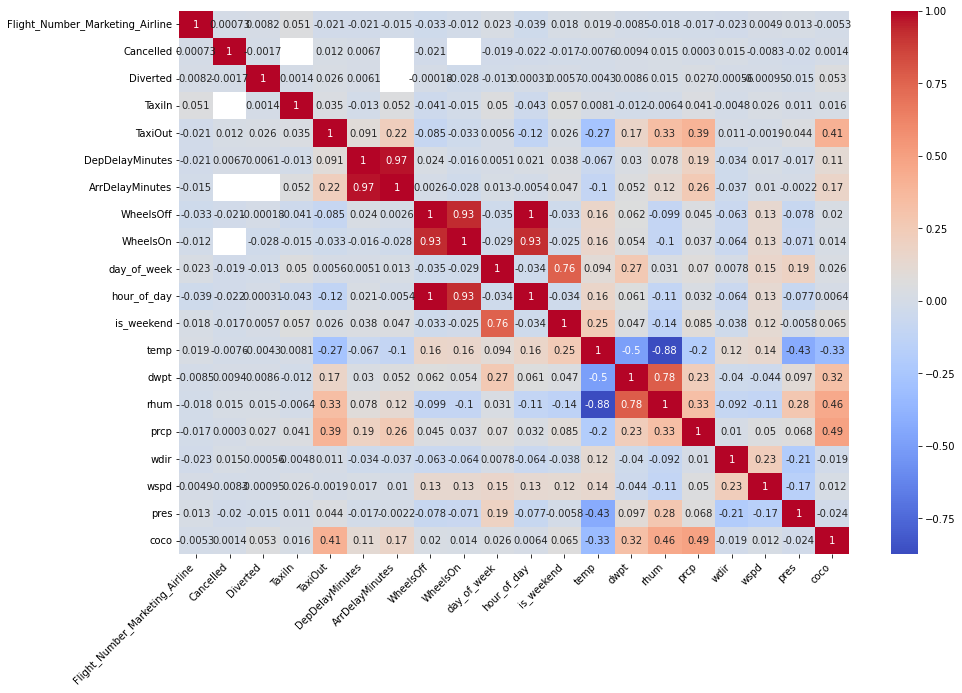

In [190]:
#how correlated are the features?
plt.figure(figsize = (15,10))
g = sns.heatmap(df.corr(), cmap="coolwarm", annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.show()

In [201]:
# Flights departure at the same time
df[df['DepDateTime'].duplicated()].sort_values('DepDateTime')

,FlightDate,Airline,Operating_Airline,Flight_Number_Marketing_Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,CRSArrTime,DepTime,ArrTime,TaxiIn,TaxiOut,DepDelayMinutes,ArrDelayMinutes,WheelsOff,WheelsOn,DepDateTime,ArrDateTime,DepDatatime_UTC,day_of_week,hour_of_day,is_weekend,DepDatatime_UTC_Hour,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco
1926,2021-03-01,SkyWest Airlines Inc.,OO,5125,DEN,ATY,False,False,09:45:00,12:23:00,09:41:00,12:15:00,3.0,13.0,0.0,0.0,954.0,1212.0,2021-03-01 09:41:00,2021-03-01 12:15:00,2021-03-01 16:41:00,0.0,9.0,0,2021-03-01 16:00:00+00:00,0.0,-14.0,34.0,0.0,210.0,13.0,1028.5,2.0
4616,2021-03-01,SkyWest Airlines Inc.,OO,5828,DEN,HDN,False,False,09:48:00,10:48:00,09:42:00,10:28:00,3.0,13.0,0.0,0.0,955.0,1025.0,2021-03-01 09:42:00,2021-03-01 10:28:00,2021-03-01 16:42:00,0.0,9.0,0,2021-03-01 16:00:00+00:00,0.0,-14.0,34.0,0.0,210.0,13.0,1028.5,2.0
1902,2021-03-01,SkyWest Airlines Inc.,OO,4707,DEN,SAT,False,False,09:46:00,12:58:00,09:42:00,12:51:00,6.0,15.0,0.0,0.0,957.0,1245.0,2021-03-01 09:42:00,2021-03-01 12:51:00,2021-03-01 16:42:00,0.0,9.0,0,2021-03-01 16:00:00+00:00,0.0,-14.0,34.0,0.0,210.0,13.0,1028.5,2.0
2095,2021-03-01,SkyWest Airlines Inc.,OO,5579,DEN,FAR,False,False,09:48:00,12:46:00,09:46:00,12:38:00,5.0,12.0,0.0,0.0,958.0,1233.0,2021-03-01 09:46:00,2021-03-01 12:38:00,2021-03-01 16:46:00,0.0,9.0,0,2021-03-01 16:00:00+00:00,0.0,-14.0,34.0,0.0,210.0,13.0,1028.5,2.0
2084,2021-03-01,SkyWest Airlines Inc.,OO,5496,DEN,XNA,False,False,10:01:00,12:53:00,09:53:00,12:44:00,5.0,19.0,0.0,0.0,1012.0,1239.0,2021-03-01 09:53:00,2021-03-01 12:44:00,2021-03-01 16:53:00,0.0,9.0,0,2021-03-01 16:00:00+00:00,0.0,-14.0,34.0,0.0,210.0,13.0,1028.5,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,2021-03-31,SkyWest Airlines Inc.,OO,5739,DEN,DRO,False,False,20:00:00,21:16:00,19:50:00,20:51:00,5.0,13.0,0.0,0.0,2003.0,2046.0,2021-03-31 19:50:00,2021-03-31 20:51:00,2021-04-01 01:50:00,2.0,19.0,0,2021-04-01 01:00:00+00:00,7.8,-10.5,26.0,0.0,100.0,18.4,1028.0,2.0
5788,2021-03-31,SkyWest Airlines Inc.,OO,4701,DEN,MOT,False,False,19:54:00,22:51:00,19:50:00,22:41:00,5.0,17.0,0.0,0.0,2007.0,2236.0,2021-03-31 19:50:00,2021-03-31 22:41:00,2021-04-01 01:50:00,2.0,19.0,0,2021-04-01 01:00:00+00:00,7.8,-10.5,26.0,0.0,100.0,18.4,1028.0,2.0
157,2021-03-31,SkyWest Airlines Inc.,OO,4775,DEN,MFR,False,False,20:00:00,21:54:00,19:50:00,21:47:00,7.0,19.0,0.0,0.0,2009.0,2140.0,2021-03-31 19:50:00,2021-03-31 21:47:00,2021-04-01 01:50:00,2.0,19.0,0,2021-04-01 01:00:00+00:00,7.8,-10.5,26.0,0.0,100.0,18.4,1028.0,2.0
5803,2021-03-31,SkyWest Airlines Inc.,OO,5050,DEN,GCC,False,False,20:15:00,21:34:00,20:10:00,21:16:00,5.0,11.0,0.0,0.0,2021.0,2111.0,2021-03-31 20:10:00,2021-03-31 21:16:00,2021-04-01 02:10:00,2.0,20.0,0,2021-04-01 02:00:00+00:00,3.3,-8.4,42.0,0.0,110.0,18.4,1029.5,2.0


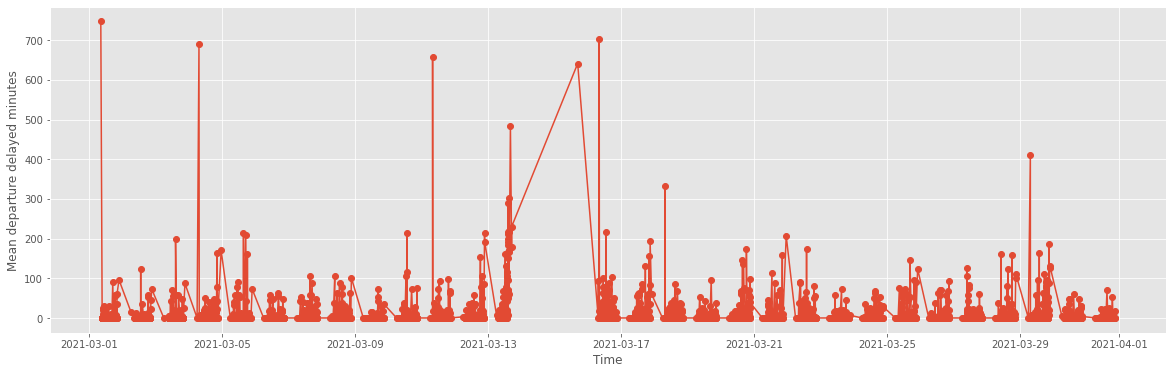

In [216]:
# plot timeseries for departur delay minutes
fig, ax = plt.subplots( figsize=(20,6))
plt.plot(df[['DepDateTime', 'DepDelayMinutes']].groupby('DepDateTime').mean(), marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Mean departure delayed minutes');

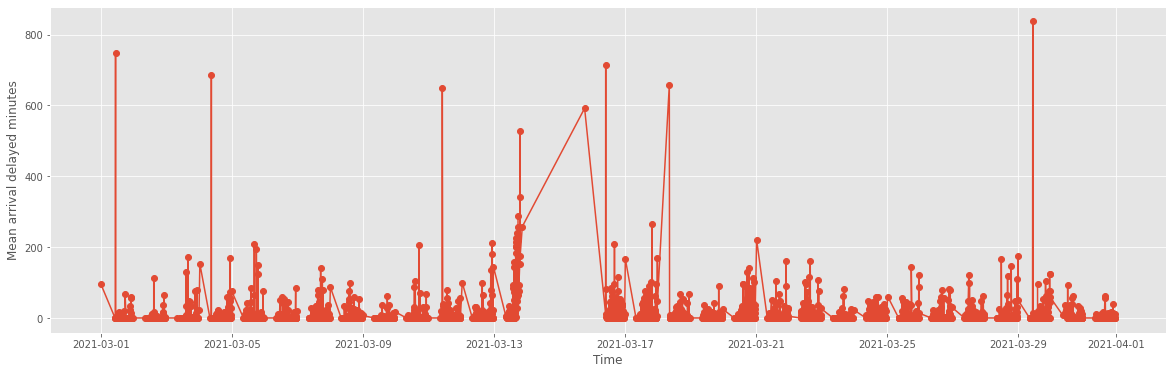

In [217]:
# plot timeserie for arrival delay minutes
fig, ax = plt.subplots( figsize=(20,6))
plt.plot(df[['ArrDateTime', 'ArrDelayMinutes']].groupby('ArrDateTime').mean(), marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Mean arrival delayed minutes');

In [220]:
df['CRSDateTime'] = pd.to_datetime(df['FlightDate'].astype(str) + ' ' + df['CRSDepTime'].astype(str), errors='coerce')

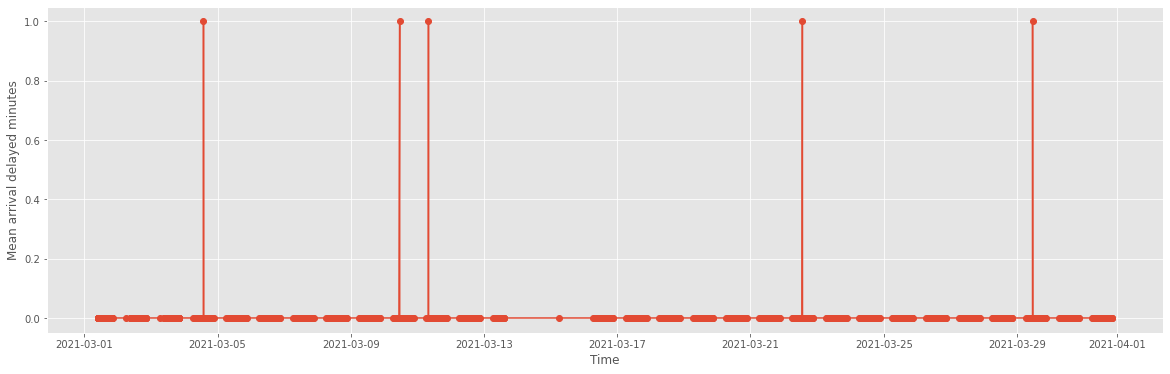

In [224]:
# plot timeseries when it is cancelled
fig, ax = plt.subplots( figsize=(20,6))
plt.plot(df[['CRSDateTime','Cancelled']].groupby('CRSDateTime').sum(), marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Mean arrival delayed minutes');

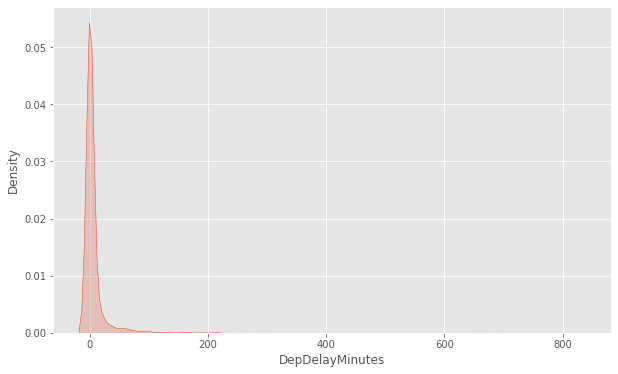

In [225]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.kdeplot(df['DepDelayMinutes'], shade=True);

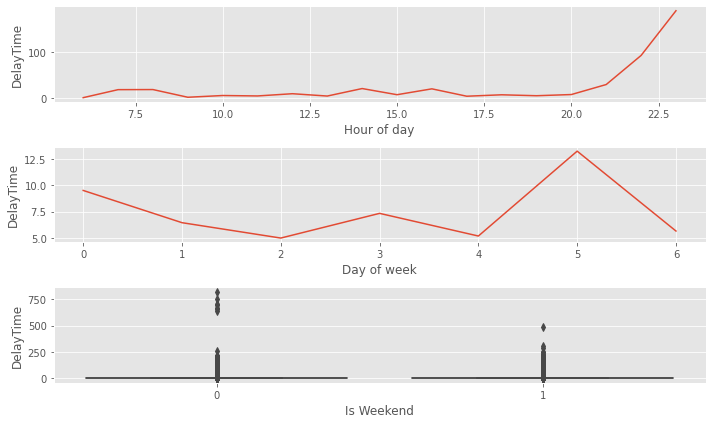

In [229]:
fig, ax = plt.subplots(3,1, figsize=(10,6))
df.groupby("hour_of_day").mean()['DepDelayMinutes'].plot(ax=ax[0])
ax[0].set_xlabel("Hour of day")
ax[0].set_ylabel("DelayTime")

df.groupby("day_of_week").mean()['DepDelayMinutes'].plot(ax=ax[1])
ax[1].set_xlabel("Day of week")
ax[1].set_ylabel("DelayTime")

ax[2] = sns.boxplot(x="is_weekend", y="DepDelayMinutes",data=df )
ax[2].set_xlabel("Is Weekend")
ax[2].set_ylabel("DelayTime")


fig.tight_layout()

In [231]:
# make a weather timeseries plot

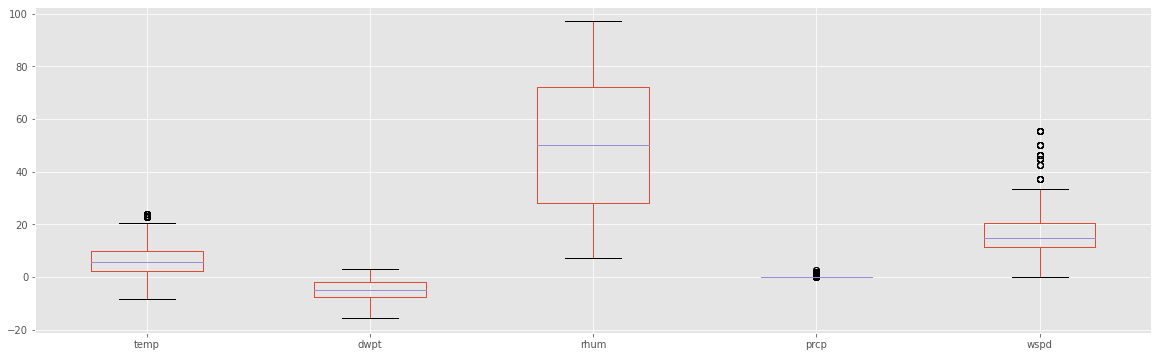

In [232]:
fig, ax = plt.subplots( figsize=(20,6))
df.boxplot(column=['temp','dwpt', 'rhum', 'prcp', 'wspd']);

## Verification AR(1)-Model

Modelling the departure delay minutes as function for one airport. 

In [242]:
# Scan function to propogate dynamics
def f(carry, noise_t):
    beta, z_prev, tau = carry
    z_t = beta*z_prev + tau*noise_t
    z_prev = z_t
    return (beta, z_prev, tau), z_t

def model(T, T_forecast, obs=None):
    # Define priors over beta, tau, noises, sigma, z_1
    beta  = numpyro.sample("beta", numpyro.distributions.Normal(0.,1.))
    tau = numpyro.sample("tau", numpyro.distributions.HalfCauchy(10.))
    sigma = numpyro.sample("sigma", numpyro.distributions.HalfCauchy(10.))
    z_1 = numpyro.sample("z_1", numpyro.distributions.Normal(0.,1.))
    noises = numpyro.sample("noises", numpyro.distributions.Normal(0.,1.),
                            sample_shape=(T+T_forecast-1,))# -1 because AR(1)
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_1, tau)
    z_collection = jnp.array([z_1])
    carry_updated, z_collection2 = lax.scan(f=f, init=carry, xs=noises, length=T+T_forecast-1)
    z_collection = jnp.concatenate((z_collection,z_collection2))
    
    # Sample the observed y (y_obs) and prediction y (y_pred)
    y_obs  = numpyro.sample("y_obs", numpyro.distributions.Normal(z_collection[:T],sigma),obs=obs[:T])
    y_pred = numpyro.sample("y_pred", numpyro.distributions.Normal(z_collection[T:],sigma),obs=None)
    
    return z_collection

In [243]:
# Ancestral sampling:

# Assume sigma and tau to be fixed
tau = 1.
print("tau:", tau)
sigma = 1.
print("sigma:", sigma)

# Length of the time-series
T = 10000

z = np.zeros(T) # Vector to store sampled latent states
y = np.zeros(T) # Vector to store sampled observations

# Sample coefficient (beta)
beta = np.random.normal(0.,1.)
print("beta:", beta)

# Sample latent states (z)
z[0] = np.random.normal(0,1.) # First latent state is sampled separately 
for t in range(1,T):
    z[t] = np.random.normal(beta * z[t-1], tau) 
print("z:", z)
    
# Sample observations (y)
for t in range(T):
    y[t] = np.random.normal(z[t], sigma)
print("y:", y)

tau: 1.0
sigma: 1.0
beta: 0.6483042105858045
z: [-0.16176662 -2.05286891 -1.07063302 ...  1.30662885 -0.06988411
 -0.95502526]
y: [ 1.80384362 -2.9748864   1.48777765 ...  1.20868537  1.35751221
 -1.99389357]


In [244]:
# Splitting in training and test set
ix_train = range(0, len(y)-100) # Indexes in the training set
ix_test = range(len(y)-100, len(y)) # Indexes in the test set
N_train = len(ix_train)
N_test = len(ix_test)
print(f'N_train: {N_train}')
print(f'N_test:, {N_test}')
y_train = y[ix_train] # Defining training set
y_test = y[ix_test] # Defining test set

N_train: 9900
N_test:, 100


In [251]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500, num_chains=1)
mcmc.run(rng_key_, T=N_train, T_forecast=N_test, obs=y_train)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|███████████████████████████| 1500/1500 [01:10<00:00, 21.13it/s, 63 steps of size 9.73e-02. acc. prob=0.84]


Total time: 1.317m


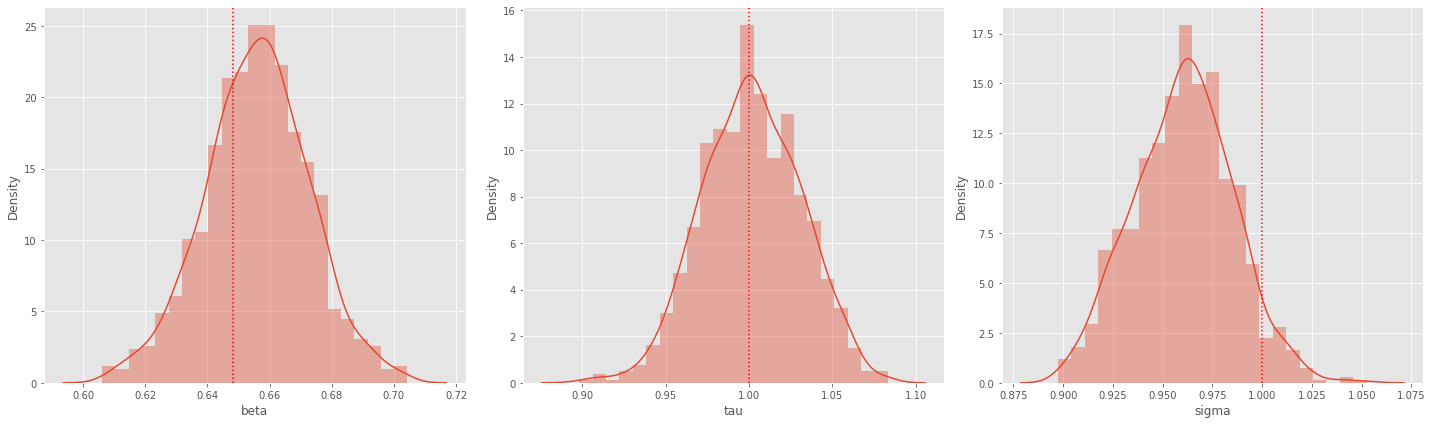

In [252]:
# Collecting samples
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

nodes = ["beta", "tau", "sigma"]
fig, axes = plt.subplots(1,3, figsize=(20,6))
axes = axes.flatten()

true_values = [beta, tau, sigma]

for i, node in enumerate(nodes):
    axes[i]
    sns.distplot(hmc_samples[node], label=node , axlabel=node, ax=axes[i]).axvline(true_values[i], color='red', ls=':')
    fig.tight_layout()

In [253]:
print("Estimated latent variables")
print("beta:", hmc_samples["beta"].mean())
print("tau:", hmc_samples["tau"].mean())
print("sigma:", hmc_samples["sigma"].mean())

Estimated latent variables
beta: 0.65600085
tau: 1.0016525
sigma: 0.9604731


In [254]:
print("True values of latent variables")
print("beta:", beta)
print("tau:", tau)
print("sigma:", sigma)

True values of latent variables
beta: 0.6483042105858045
tau: 1.0
sigma: 1.0


The AR(1) is working. 

## Stationarity and Transformations

In [255]:
y = df[['DepDateTime', 'DepDelayMinutes']].groupby('DepDateTime').mean()

In [256]:
import statsmodels.tsa.stattools as sts
f"Is timeseries {sts.adfuller(y)[1]} stationary?: {sts.adfuller(y)[1] < 0.05}"

'Is timeseries 1.9148116795927937e-15 stationary?: True'

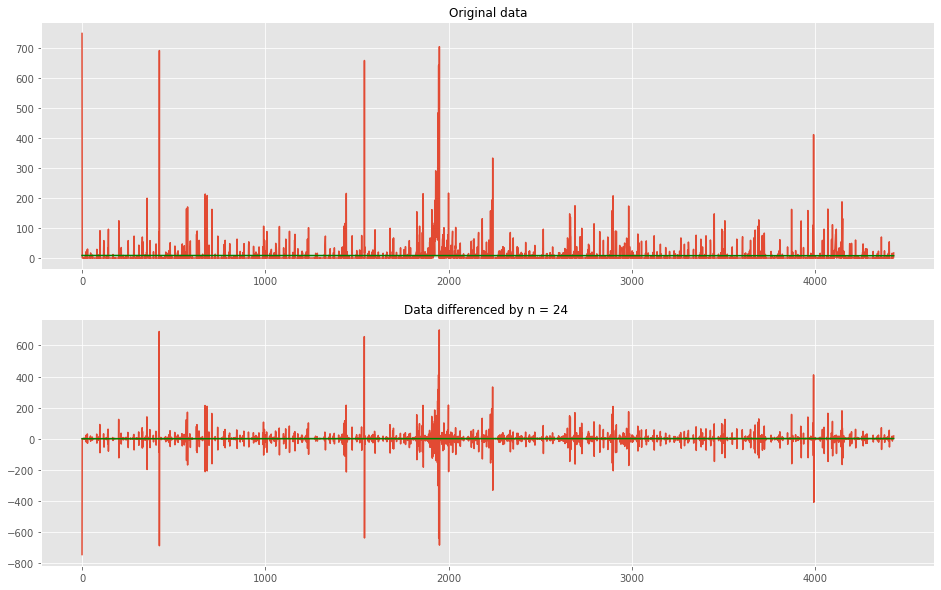

In [275]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10))

x = range(0, y.shape[0])

# No transformation
p = np.poly1d( np.polyfit(x, y['DepDelayMinutes'].dropna(), 1))
ax[0].plot(x,y)
ax[0].plot(x, p(x), "g-")
ax[0].set_title('Original data', fontsize=12);

# Difference for 24 hours to capture hourly flucutations
x24 = range(0, y['DepDelayMinutes'].diff(1).dropna().shape[0])
p_diff24 = np.poly1d(np.polyfit(x24, y['DepDelayMinutes'].diff(1).dropna(), 1))
ax[1].plot(x24,y['DepDelayMinutes'].diff(1).dropna())
ax[1].plot(x24, p_diff24(x24), "g-")
ax[1].set_title('Data differenced by n = 24 ', fontsize=12);


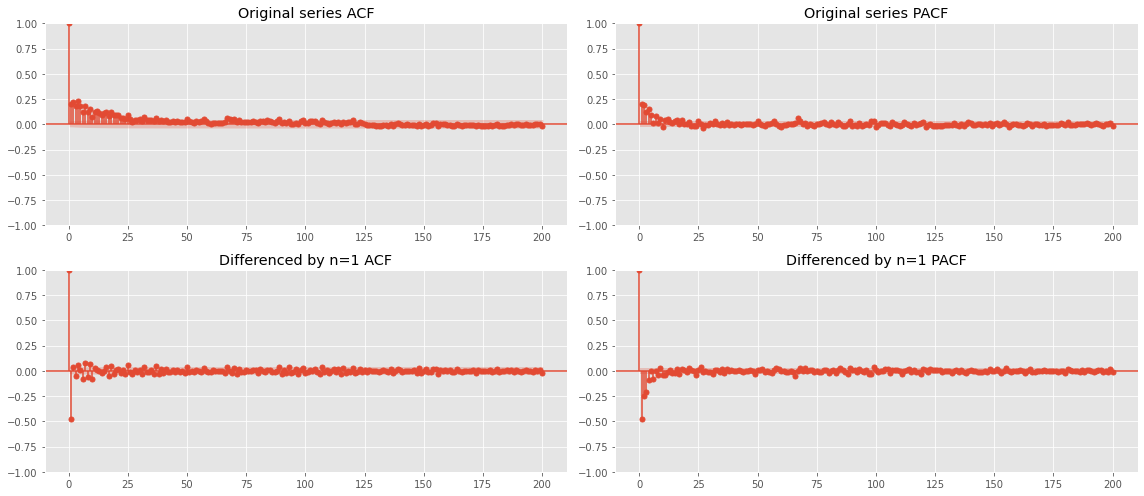

In [279]:
fig, axes = plt.subplots(2,2, figsize=(16,7))
axes = axes.flatten()
sm.graphics.tsa.plot_acf(y['DepDelayMinutes'],title='Original series ACF',lags=200, ax=axes[0]);
sm.graphics.tsa.plot_pacf(y['DepDelayMinutes'],title='Original series PACF',lags=200, ax=axes[1]);
sm.graphics.tsa.plot_acf(y['DepDelayMinutes'].diff(1).dropna(),title='Differenced by n=1 ACF',lags=200, ax=axes[2]);
sm.graphics.tsa.plot_pacf(y['DepDelayMinutes'].diff(1).dropna(),title='Differenced by n=1 PACF',lags=200, ax=axes[3]);
fig.tight_layout()

##  Temporal models

In [290]:
X = df[df.Cancelled==True]
X = df.groupby('DepDateTime').mean().drop(['Diverted','Cancelled','DepDelayMinutes','ArrDelayMinutes'],axis=1)
y = df.groupby('DepDateTime').mean()['DepDelayMinutes']

In [293]:
# Split in train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=False)

In [294]:
# Scan function to propogate dynamics
def f(carry, noise_t):
    beta, z_prev, tau = carry
    z_t = beta*z_prev + tau*noise_t
    z_prev = z_t
    return (beta, z_prev, tau), z_t

def model(T, T_forecast, obs=None):
    # Define priors over beta, tau, noises, sigma, z_1
    beta  = numpyro.sample("beta", numpyro.distributions.Normal(0.,1.))
    tau = numpyro.sample("tau", numpyro.distributions.HalfCauchy(.01))
    sigma = numpyro.sample("sigma", numpyro.distributions.HalfCauchy(.01))
    z_1 = numpyro.sample("z_1", numpyro.distributions.Normal(0.,1.))
    noises = numpyro.sample("noises", numpyro.distributions.Normal(0.,1.),
                            sample_shape=(T+T_forecast-1,))# -1 because AR(1)
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_1, tau)
    z_collection = jnp.array([z_1])
    carry_updated, z_collection2 = lax.scan(f=f, init=carry, xs=noises, length=T+T_forecast-1)
    z_collection = jnp.concatenate((z_collection,z_collection2))
    
    # Sample the observed y (y_obs) and prediction y (y_pred)
    y_obs  = numpyro.sample("y_obs", numpyro.distributions.Normal(z_collection[:T],sigma),obs=obs[:T])
    y_pred = numpyro.sample("y_pred", numpyro.distributions.Normal(z_collection[T:],sigma),obs=None)
    
    return z_collection

In [295]:
# Inference 

from numpyro.infer import MCMC, NUTS

t0 = time.time()
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=len(y_train), T_forecast=len(y_test), obs=y.values)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|████████████████████████████| 3000/3000 [00:50<00:00, 59.09it/s, 1 steps of size 1.27e-01. acc. prob=0.70]


Total time: 0.958m


In [320]:
hmc_samples["y_pred"][2]

DeviceArray([-3.39890146e+00, -3.86217237e-02,  7.03142309e+00,
              4.50150604e+01,  4.22038956e+01,  8.95287323e+00,
              5.44377060e+01, -1.02981005e+01, -5.67318726e+01,
             -8.16448822e+01, -3.81987953e+01, -1.59846163e+00,
              1.55170259e+01,  1.53044386e+01, -4.08470535e+00,
              9.61847591e+00,  1.09081602e+01, -4.25578728e+01,
              3.44224834e+00, -3.07763405e+01,  1.99803317e+00,
              4.66518936e+01, -2.65999336e+01, -2.66727371e+01,
             -2.79243240e+01,  8.60183640e+01, -5.68223143e+00,
             -2.53012581e+01, -2.26813202e+01,  2.12724304e+01,
             -2.30235457e+00, -8.44462872e+00, -1.43739672e+01,
             -4.23724823e+01, -6.47720098e+00,  2.53589134e+01,
              3.82853966e+01, -1.03623228e+01,  1.09606810e+01,
              4.17831459e+01, -2.12062111e+01, -1.30143185e+01,
             -2.48438950e+01, -1.37751245e+01,  1.69914207e+01,
             -1.16674032e+01, -4.9736610

In [296]:
# Extracting samples
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
hmc_samples["y_pred"]

DeviceArray([[-4.5593910e+01,  3.4095547e+01, -4.4420620e+01, ...,
              -2.8495337e+01, -2.8369431e+01,  1.5822935e+01],
             [ 2.4475982e+00,  1.1760608e+00,  1.0482391e+01, ...,
              -1.8718239e+01,  3.6314209e+01,  2.1065517e+01],
             [-3.3989015e+00, -3.8621724e-02,  7.0314231e+00, ...,
              -2.4230267e+01,  2.8021692e+01,  1.5644733e+01],
             ...,
             [-9.2701626e+00,  3.4998158e+01,  9.5112600e+00, ...,
               8.2384575e+01, -3.4951118e+01,  6.1652443e+01],
             [-9.2701626e+00,  3.4998158e+01,  9.5112600e+00, ...,
               8.2384575e+01, -3.4951118e+01,  6.1652443e+01],
             [-9.2701626e+00,  3.4998158e+01,  9.5112600e+00, ...,
               8.2384575e+01, -3.4951118e+01,  6.1652443e+01]],            dtype=float32)

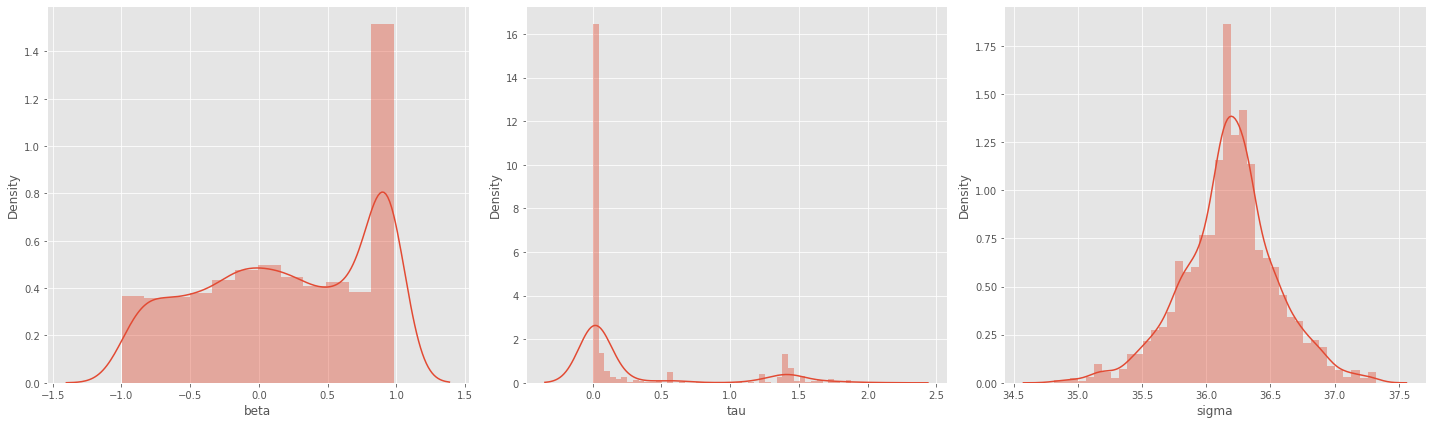

In [297]:
# Visualization of the posterior distributions
nodes = ["beta", "tau", "sigma"]
fig, axes = plt.subplots(1,3, figsize=(20,6))
axes = axes.flatten()
for i, node in enumerate(nodes):
    axes[i]
    sns.distplot(hmc_samples[node], label=node , axlabel=node, ax=axes[i])
    fig.tight_layout()

In [312]:
y.loc[y_test.index].shape

(443,)

In [356]:
plot_df = pd.DataFrame()
plot_df['true'] = y.loc[y_test.index]
plot_df['preds'] = np.array(hmc_samples["y_pred"].mean(axis=0))

<Axes: xlabel='DepDateTime'>

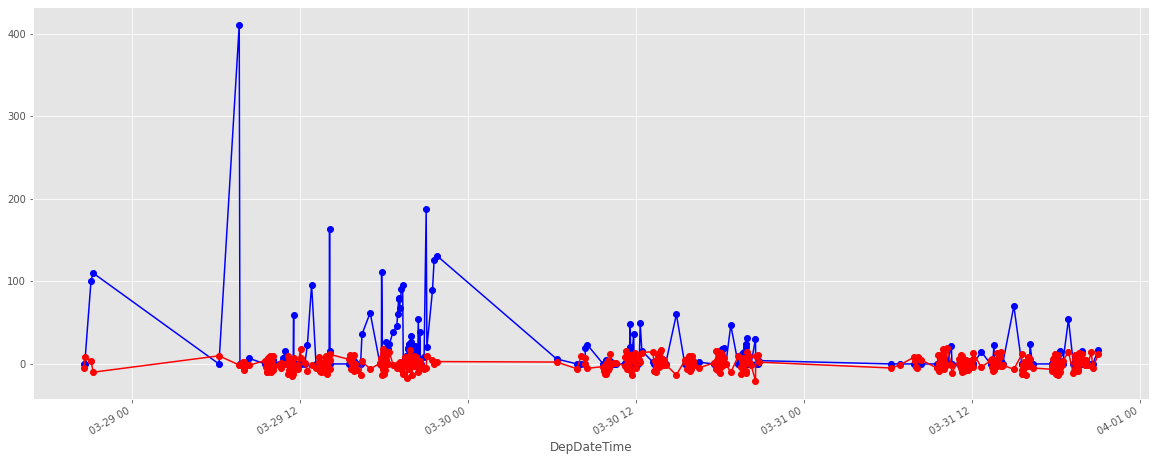

In [358]:
fig, ax = plt.subplots( figsize = (20, 8))
plot_df['true'].plot(style='b-', marker='o')
plot_df['preds'].plot(style='r-', marker='o')

## AR1 with External Features